# Séries temporais com Regressão Linear

**Autor**: [Maykon Schots](https://www.linkedin.com/in/maykon-schots/)

**Participação especial**: [Rafael Barbosa](https://www.linkedin.com/in/rafael-barbosa0/)

**Objetivo**: Temos uma série temporal de frequência diária de vendas que inicia em Jan/2020 e termina no final de Jul/2020. Queremos prever estas vendas para a próxima semana, dada as características que estão presentes no banco de dados abaixo. 

## 1. Bibliotecas e configurações adicionais

In [1]:
#--- Bibliotecas iniciais

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays


#--- Configurações adicionais

plt.style.use("seaborn-muted")
pd.set_option("display.max_columns", None)

In [2]:
dados = pd.read_csv("data/output-dados-case.csv")
dados["Lead Created At"] = pd.to_datetime(dados["Lead Created At"], format = "%Y-%m-%d")

dados.head()

,Lead Created At,Lead Id,Purchase Source,JID,tempo_jornada,flag_jornada,flag_venda,Canal
0,2020-01-06 22:39:00,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,fb-geral-lookalike-dco,1,1.0,Primeiro Contato,0.0,FB
1,2020-02-21 19:18:00,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,sms-pre-carnaval-abandono,2,47.0,Ultimo Contato,0.0,SMS
2,2020-05-13 14:15:00,MSS-000031d0-5499-4e58-a88d-9afbcbb8ee9a-2019,yt-rmkt-videos-videovendas3,3,143.0,Ultimo Contato,0.0,YT
3,2020-07-23 22:28:00,MSS-00003bb2-b409-47b3-862f-e6c82b311d0c-2020,insta-bio,1,1.0,Primeiro Contato,0.0,FB
4,2020-05-12 22:51:00,MSS-0000610b-1170-47f5-990b-239d6eaef81b-2020,fb-rmkt-video-dco,1,1.0,Primeiro Contato,0.0,FB


---

- Observando o banco de dados, temos a informação de todas as interações em que o cliente teve com a loja

- A variável **flag_venda** indica se esta determinada interação cliente-loja resultou em uma compra ou não

- Então, o caminho para criar a nossa série temporal de vendas é:

    - Criar uma nova variável que sempre vai ter o valor de 1, indicando a interação quantitativamente
    
    - Filtrar somente as observações em que houveram venda
    
    - Com isso, faremos uma agregação da soma de todas as vendas por dia
    
---

In [3]:
dados["indicador_leads"] = 1

vol_diarios_compras = dados[dados["flag_venda"] == 1].resample("D", on = "Lead Created At")["indicador_leads"].sum()
vol_diarios_compras.head()

Lead Created At
2020-01-01    47
2020-01-02    70
2020-01-03    48
2020-01-04    81
2020-01-05    73
Freq: D, Name: indicador_leads, dtype: int64

## 2. Visualização da série temporal

- A série possui uma tendência de queda desde o início do ano

- Por determinado motivo, teve um pico no início de Julho

- Entretanto, mesmo com o pico de Julho, a série voltou ao padrão normal de queda

---

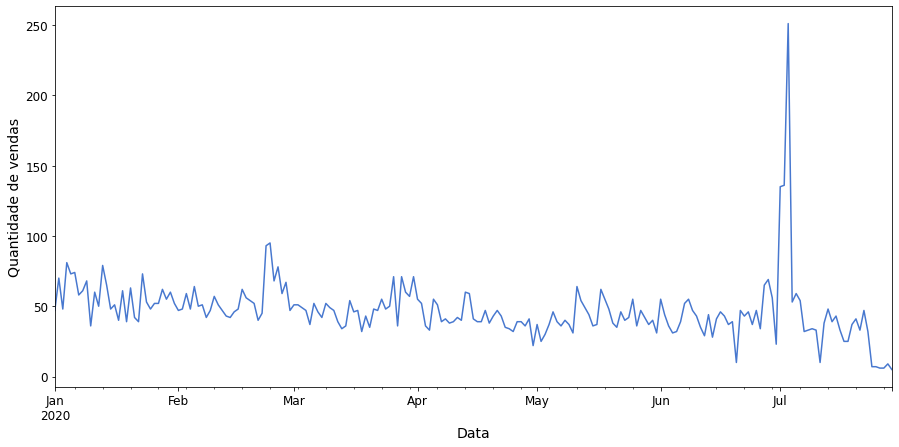

In [4]:
_ = plt.figure(figsize = [15, 7])
_ = vol_diarios_compras.plot(kind = "line")
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

## 3. Variáveis para a modelagem

- Abaixo podemos ver algumas *features* explicativas para melhorar o poder preditivo do modelo

### 3.1. Variável resposta: Quantidade de compras por mês 

In [5]:
dados1 = pd.DataFrame(vol_diarios_compras).reset_index()

dados1["indicador_leads"] = dados1["indicador_leads"]*1.0

dados1.head()

,Lead Created At,indicador_leads
0,2020-01-01,47.0
1,2020-01-02,70.0
2,2020-01-03,48.0
3,2020-01-04,81.0
4,2020-01-05,73.0


### 3.2. Variável explicativa: Volume diário médio da jornada

In [6]:
dados2 = pd.DataFrame(dados.resample("D", on = "Lead Created At")["tempo_jornada"].mean()).reset_index()

dados2.head()

,Lead Created At,tempo_jornada
0,2020-01-01,29.451766
1,2020-01-02,27.240385
2,2020-01-03,33.897341
3,2020-01-04,27.859436
4,2020-01-05,35.575490


### 3.3. Join entre as primeiras variáveis

In [7]:
of_dados = pd.merge(dados1, dados2, on = ["Lead Created At"])

of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada
0,2020-01-01,47.0,29.451766
1,2020-01-02,70.0,27.240385
2,2020-01-03,48.0,33.897341
3,2020-01-04,81.0,27.859436
4,2020-01-05,73.0,35.575490


### 3.4. Variável explicativa: É feriado?

In [8]:
feriados = holidays.Brazil()

feriados_br = pd.DataFrame({"x": feriados["2020-01-01": "2020-07-31"]})
feriados_br["x"] = pd.to_datetime(feriados_br["x"], format = "%Y-%m-%d")

of_dados = pd.merge(of_dados, feriados_br, how="left", indicator = True, left_on = "Lead Created At", right_on= "x")
of_dados["feriado"] = np.where(of_dados["_merge"] == "both", 1, 0)
of_dados = of_dados.drop(["x", "_merge"], axis = 1)


of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado
0,2020-01-01,47.0,29.451766,1
1,2020-01-02,70.0,27.240385,0
2,2020-01-03,48.0,33.897341,0
3,2020-01-04,81.0,27.859436,0
4,2020-01-05,73.0,35.575490,0


### 3.5. Variável explicativa: Comuns de séries temporais

In [9]:
import datetime

of_dados["day"] = of_dados["Lead Created At"].apply(lambda t: t.day)
of_dados["weekday"] = of_dados["Lead Created At"].apply(lambda x: x.weekday())

of_dados.head()

,Lead Created At,indicador_leads,tempo_jornada,feriado,day,weekday
0,2020-01-01,47.0,29.451766,1,1,2
1,2020-01-02,70.0,27.240385,0,2,3
2,2020-01-03,48.0,33.897341,0,3,4
3,2020-01-04,81.0,27.859436,0,4,5
4,2020-01-05,73.0,35.575490,0,5,6


### 3.6. Variável explicativa: É fim de semana?

In [10]:
of_dados["is_weekend"] = of_dados["weekday"].apply(lambda x: 1 if x in (5, 6) else 0)

of_dados.head(15)

,Lead Created At,indicador_leads,tempo_jornada,feriado,day,weekday,is_weekend
0,2020-01-01,47.0,29.451766,1,1,2,0
1,2020-01-02,70.0,27.240385,0,2,3,0
2,2020-01-03,48.0,33.897341,0,3,4,0
3,2020-01-04,81.0,27.859436,0,4,5,1
4,2020-01-05,73.0,35.575490,0,5,6,1
5,2020-01-06,74.0,33.169906,0,6,0,0
6,2020-01-07,58.0,30.710322,0,7,1,0
7,2020-01-08,61.0,31.103306,0,8,2,0
8,2020-01-09,68.0,36.669271,0,9,3,0
9,2020-01-10,36.0,36.791209,0,10,4,0


### 3.7. Variável explicativa: Lags

In [11]:
var_lags = list(of_dados.drop(["Lead Created At", "indicador_leads"], axis = 1).columns)

var_lags

['tempo_jornada', 'feriado', 'day', 'weekday', 'is_weekend']

In [12]:
#--- https://medium.com/@rayheberer/generating-lagged-pandas-columns-10397309ccaf (Deus abençoe esse Rapaz)

df_lagged = of_dados[var_lags].copy()
trailing_window_size = 10

for window in range(1, trailing_window_size + 1):
    
    shifted = of_dados[var_lags].shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in of_dados[var_lags].columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis = 1)
    
df_lagged = df_lagged.dropna().reset_index(drop = True)
df_lagged = df_lagged.drop(columns = var_lags)

df_lagged.head()


#--- Porque isso não deu certo?

# for i in range(4, 10):

#     of_dados[var_lags + f"lag{i}"] = of_dados[var_lags].shift(i)

,tempo_jornada_lag1,feriado_lag1,day_lag1,weekday_lag1,is_weekend_lag1,tempo_jornada_lag2,feriado_lag2,day_lag2,weekday_lag2,is_weekend_lag2,tempo_jornada_lag3,feriado_lag3,day_lag3,weekday_lag3,is_weekend_lag3,tempo_jornada_lag4,feriado_lag4,day_lag4,weekday_lag4,is_weekend_lag4,tempo_jornada_lag5,feriado_lag5,day_lag5,weekday_lag5,is_weekend_lag5,tempo_jornada_lag6,feriado_lag6,day_lag6,weekday_lag6,is_weekend_lag6,tempo_jornada_lag7,feriado_lag7,day_lag7,weekday_lag7,is_weekend_lag7,tempo_jornada_lag8,feriado_lag8,day_lag8,weekday_lag8,is_weekend_lag8,tempo_jornada_lag9,feriado_lag9,day_lag9,weekday_lag9,is_weekend_lag9,tempo_jornada_lag10,feriado_lag10,day_lag10,weekday_lag10,is_weekend_lag10
0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0,29.451766,1.0,1.0,2.0,0.0
1,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0
2,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0
3,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0
4,35.091618,0.0,14.0,1.0,0.0,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0


In [13]:
df_lagged.shape

(201, 50)

In [14]:
df_lagged.head()

,tempo_jornada_lag1,feriado_lag1,day_lag1,weekday_lag1,is_weekend_lag1,tempo_jornada_lag2,feriado_lag2,day_lag2,weekday_lag2,is_weekend_lag2,tempo_jornada_lag3,feriado_lag3,day_lag3,weekday_lag3,is_weekend_lag3,tempo_jornada_lag4,feriado_lag4,day_lag4,weekday_lag4,is_weekend_lag4,tempo_jornada_lag5,feriado_lag5,day_lag5,weekday_lag5,is_weekend_lag5,tempo_jornada_lag6,feriado_lag6,day_lag6,weekday_lag6,is_weekend_lag6,tempo_jornada_lag7,feriado_lag7,day_lag7,weekday_lag7,is_weekend_lag7,tempo_jornada_lag8,feriado_lag8,day_lag8,weekday_lag8,is_weekend_lag8,tempo_jornada_lag9,feriado_lag9,day_lag9,weekday_lag9,is_weekend_lag9,tempo_jornada_lag10,feriado_lag10,day_lag10,weekday_lag10,is_weekend_lag10
0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0,29.451766,1.0,1.0,2.0,0.0
1,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0,27.240385,0.0,2.0,3.0,0.0
2,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0,33.897341,0.0,3.0,4.0,0.0
3,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0,27.859436,0.0,4.0,5.0,1.0
4,35.091618,0.0,14.0,1.0,0.0,36.030043,0.0,13.0,0.0,0.0,35.558354,0.0,12.0,6.0,1.0,33.674134,0.0,11.0,5.0,1.0,36.791209,0.0,10.0,4.0,0.0,36.669271,0.0,9.0,3.0,0.0,31.103306,0.0,8.0,2.0,0.0,30.710322,0.0,7.0,1.0,0.0,33.169906,0.0,6.0,0.0,0.0,35.575490,0.0,5.0,6.0,1.0


In [15]:
y = of_dados.loc[10:, "indicador_leads"]

y.head()

10    60.0
11    50.0
12    79.0
13    65.0
14    48.0
Name: indicador_leads, dtype: float64

In [16]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
x = sc_x.fit_transform(df_lagged)
x = pd.DataFrame(x)

x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.609270,-0.189954,-0.699250,0.495362,-0.636863,-0.623400,-0.189954,-0.807616,-0.007449,-0.636863,-1.518036,-0.189954,-0.915630,-0.514079,-0.636863,-1.563769,-0.189954,-1.022903,-1.006278,-0.629153,-1.152154,-0.189954,-1.129050,-1.492326,-0.621455,-0.752093,-0.189954,-1.233698,1.504700,1.589439,-1.980130,-0.189954,-1.336490,0.998155,1.570197,-0.994906,-0.189954,-1.437093,0.495362,-0.636863,-2.043667,-0.189954,-1.535205,-0.007449,-0.636863,-1.667913,4.911721,-1.630553,-0.514079,-0.636863
1,-1.119383,-0.189954,-0.582515,0.993201,1.570197,-0.603451,-0.189954,-0.690494,0.491635,-0.636863,-0.608273,-0.189954,-0.798256,-0.012478,-0.636863,-1.499763,-0.189954,-0.905415,-0.503139,-0.629153,-1.553299,-0.189954,-1.011587,-0.990724,-0.621455,-1.144595,-0.189954,-1.116397,-1.489802,-0.629153,-0.732673,-0.189954,-1.219489,1.495994,1.570197,-1.974794,-0.189954,-1.320525,0.993201,1.570197,-0.971758,-0.189954,-1.419199,0.491635,-0.636863,-2.021512,-0.203595,-1.515232,-0.012478,-0.636863
2,-0.811028,-0.189954,-0.465780,1.491040,1.570197,-1.113384,-0.189954,-0.573372,0.990718,1.570197,-0.588342,-0.189954,-0.680883,0.489123,-0.636863,-0.593223,-0.189954,-0.787927,0.000000,-0.629153,-1.489205,-0.189954,-0.894123,-0.489123,-0.621455,-1.545908,-0.189954,-0.999097,-0.990718,-0.629153,-1.121585,-0.189954,-1.102488,-1.491040,-0.636863,-0.722560,-0.189954,-1.203957,1.491040,1.570197,-1.943987,-0.189954,-1.303193,0.990718,1.570197,-0.957066,-0.203595,-1.399912,0.489123,-0.636863
3,-0.733836,-0.189954,-0.349044,-1.495994,-0.636863,-0.805138,-0.189954,-0.456250,1.489802,1.570197,-1.097831,-0.189954,-0.563509,0.990724,1.570197,-0.573362,-0.189954,-0.670440,0.503139,-0.629153,-0.581427,-0.189954,-0.776660,0.012478,-0.621455,-1.481787,-0.189954,-0.881796,-0.491635,-0.629153,-1.519227,-0.189954,-0.985487,-0.993201,-0.636863,-1.112961,-0.189954,-1.087389,-1.495994,-0.636863,-0.701541,-0.189954,-1.187187,1.489802,1.570197,-1.922526,-0.203595,-1.284591,0.990724,1.570197
4,-0.887410,-0.189954,-0.232309,-0.998155,-0.636863,-0.727973,-0.189954,-0.339129,-1.504700,-0.636863,-0.789854,-0.189954,-0.446136,1.492326,1.570197,-1.081047,-0.189954,-0.552952,1.006278,1.589439,-0.561540,-0.189954,-0.659197,0.514079,-0.621455,-0.573629,-0.189954,-0.764496,0.007449,-0.629153,-1.455693,-0.189954,-0.868486,-0.495362,-0.636863,-1.512125,-0.189954,-0.970821,-0.998155,-0.636863,-1.088890,-0.189954,-1.071180,-1.504700,-0.636863,-0.688730,-0.203595,-1.169271,1.492326,1.570197


In [17]:
#--- https://www.kaggle.com/antoinekrajnc/simplest-time-series-using-linear-regression

def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(x)*(1-test_size))
    
        X_train = x.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = x.iloc[test_index:]
        y_test = y.iloc[test_index:]
        
        return X_train, y_train, X_test, y_test
    
x_treino, y_treino, x_teste, y_teste = TimeSeriesTrainTestSplit(x, y, 0.2)

In [18]:
from sklearn.linear_model import LinearRegression

reg_lin = LinearRegression()

reg_lin.fit(x_treino, y_treino)

LinearRegression()

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

ts_cross_val = TimeSeriesSplit(n_splits = 5)

cv_ts = cross_val_score(reg_lin, x_treino, y_treino, cv = ts_cross_val, scoring = "neg_mean_squared_error")
cv_ts

array([-10973.4784588 ,   -152.26855678,  -3851.55824383,   -207.49293191,
         -130.81686925])

In [20]:
y_pred = reg_lin.predict(x_teste)

y_pred[:6]

array([37.32032547, 35.89845047, 47.12891922, 54.39356766, 49.11231766,
       44.80372391])

In [21]:
y_teste.head()

170    39.0
171    10.0
172    47.0
173    43.0
174    46.0
Name: indicador_leads, dtype: float64

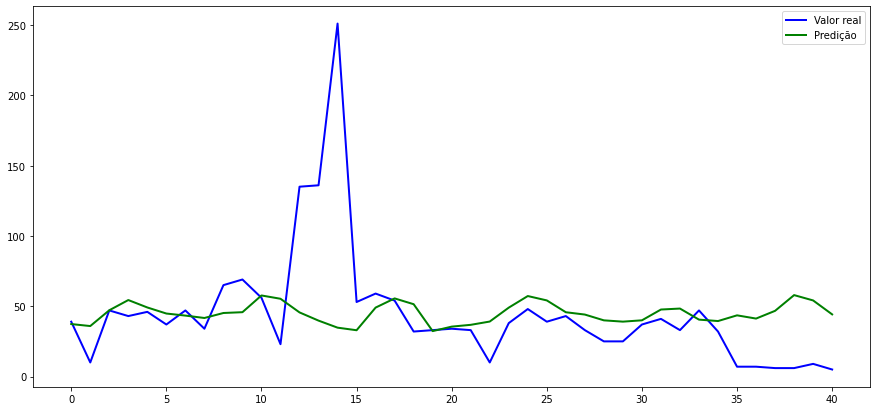

In [22]:
_ = plt.figure(figsize = (15, 7))
_ = plt.plot(y_teste.values, "blue", label = "Valor real", linewidth = 2)
_ = plt.plot(y_pred, "green", label = "Predição", linewidth = 2)
_ = plt.legend(loc = "best")

# Próxima missão:

- Tratar outlier 

---

## Testes

In [23]:
# x = of_dados.dropna().drop(["Lead Created At", "indicador_leads", "tempo_jornada", "feriado", "day", "weekday", "is_weekend"], 
#                             axis = 1).reset_index(drop = True)
    
# x.shape

In [24]:
# y = of_dados.dropna()["indicador_leads"]

# y.shape

In [25]:
# from sklearn.preprocessing import StandardScaler

# sc_x = StandardScaler()
# x = sc_x.fit_transform(x)
# x = pd.DataFrame(x)

In [26]:
# #--- https://www.kaggle.com/antoinekrajnc/simplest-time-series-using-linear-regression

# def TimeSeriesTrainTestSplit(x, y, test_size):
    
#         test_index = int(len(x)*(1-test_size))
    
#         X_train = x.iloc[:test_index]
#         y_train = y.iloc[:test_index]
#         X_test = x.iloc[test_index:]
#         y_test = y.iloc[test_index:]
        
#         return X_train, y_train, X_test, y_test
    
# x_treino, y_treino, x_teste, y_teste = TimeSeriesTrainTestSplit(x, y, 0.2)

In [27]:
# from sklearn.linear_model import LinearRegression

# reg_lin = LinearRegression()

# reg_lin.fit(x_treino, y_treino)

In [28]:
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import cross_val_score

# ts_cross_val = TimeSeriesSplit(n_splits = 5)

# cv_ts = cross_val_score(reg_lin, x_treino, y_treino, cv = ts_cross_val, scoring = "neg_mean_squared_error")
# cv_ts

In [29]:
# y_pred = reg_lin.predict(x_teste)

# y_pred

In [30]:
# _ = plt.figure(figsize = (15, 7))
# _ = plt.plot(y_teste.values, "blue", label = "Valor real", linewidth = 2)
# _ = plt.plot(y_pred, "green", label = "Predição", linewidth = 2)
# _ = plt.legend(loc = "best")

In [31]:
# plt.figure(figsize=(20,8))
# plt.plot(regressor.predict(X_test[-400:]), "y", label="prediction", linewidth=2.0)
# plt.plot(y_test.values[-400:], "g", label="real_values", linewidth=2.0)
# plt.legend(loc="best")